<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Estimate-Moving-Average" data-toc-modified-id="Estimate-Moving-Average-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Estimate Moving Average</a></span></li><li><span><a href="#Pairs-trading" data-toc-modified-id="Pairs-trading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pairs trading</a></span></li><li><span><a href="#Moje" data-toc-modified-id="Moje-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Moje</a></span></li></ul></div>

In [43]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import  poly1d

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime


In [45]:
tau = .1

kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 2, 
    initial_state_mean = [30,10],
    initial_state_covariance = np.eye(2),
    transition_matrices = [[1,tau], [0,1]],
    observation_matrices = [[1,0]],
    observation_covariance = 3,
    transition_covariance = np.zeros((2,2)),
    transition_offsets = [-4.9 * tau * 2, -9.8 * tau])


In [47]:

# simulation: ball falling for 40 units of time (each of length tau)

times = np.arange(40)
actual = -4.9 * tau ** 2 * times ** 2

# noisy camera data:
sim = actual * 3*np.random.randn(40)

# run filter on camera data:

state_means, state_covs = kf.filter(sim)

Text(0, 0.5, 'Height')

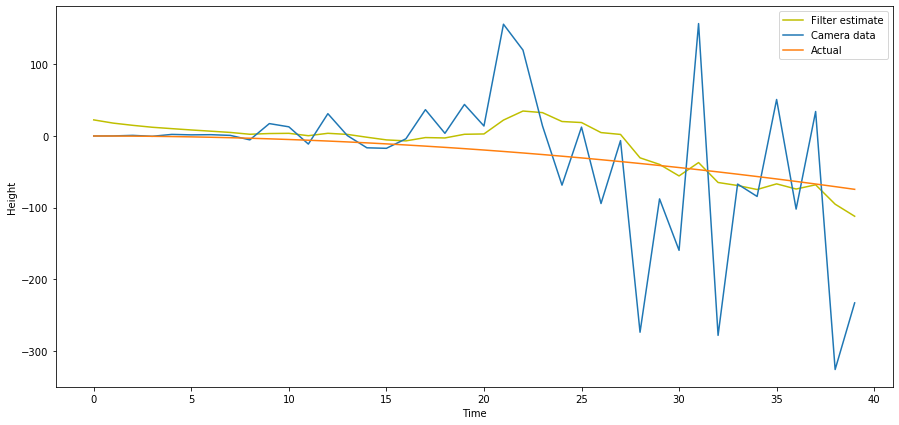

In [55]:
plt.figure(figsize = (15,7))
plt.plot(times,state_means[:,0], color = 'y')
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height')

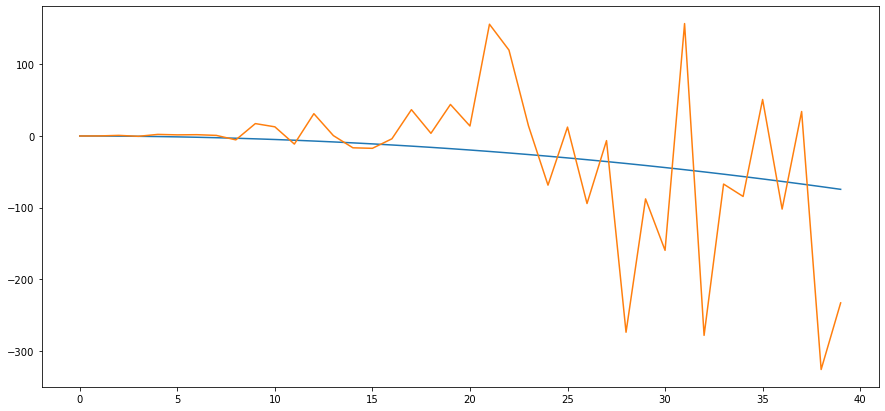

In [51]:
plt.figure(figsize = (15,7))
plt.plot(actual)
plt.plot(sim)

Text(0.5, 0, 'Time')

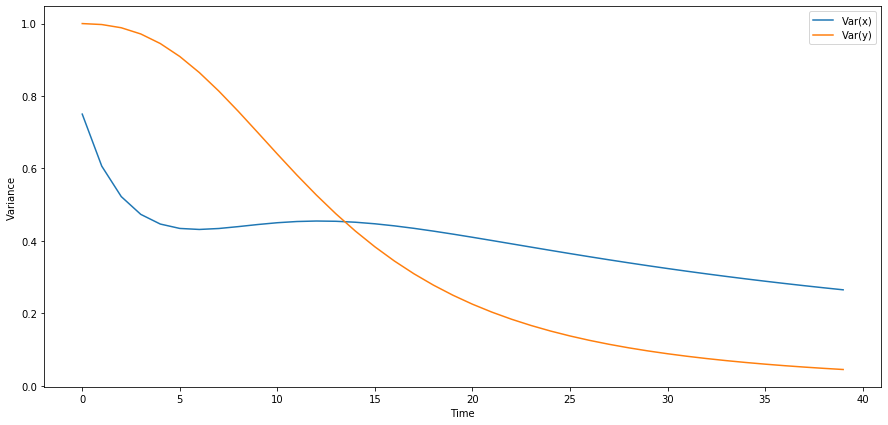

In [57]:
plt.figure(figsize = (15,7))
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(y)'])
plt.ylabel('Variance')
plt.xlabel('Time')

Text(0, 0.5, 'Height')

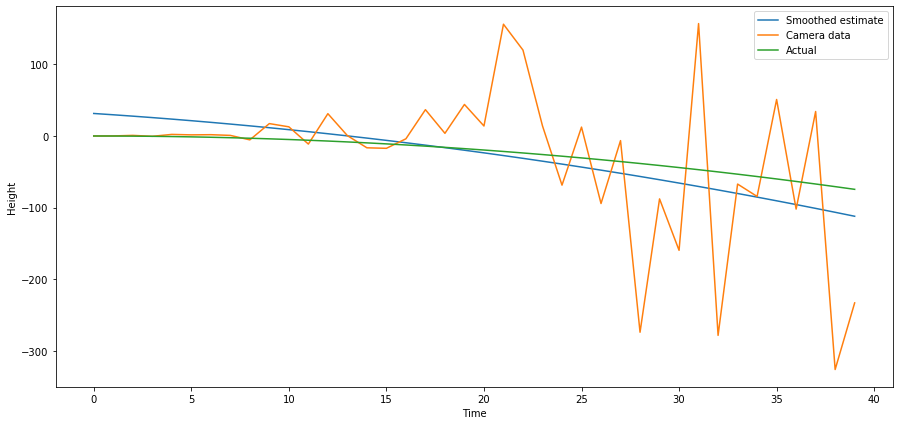

In [58]:
smoothed_state_means, _ = kf.smooth(sim)

plt.figure(figsize = (15,7))
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height')


# Estimate Moving Average

In [60]:
from pykalman import KalmanFilter
from backtester.dataSource.yahoo_data_source import YahooStockDataSource

startDateStr = '2012/12/31'
endDateStr = '2017/12/31'
cachedFolderName = '.yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY', 'MSFT', 'ADBE']

ds = YahooStockDataSource(cachedFolderName = cachedFolderName,
    dataSetId = dataSetId,
    instrumentIds = instrumentIds,
    startDateStr = startDateStr,
    endDateStr = endDateStr,
    event = 'history')

data = ds.getBookDataByFeature()['adjClose']

S1 = data['ADBE'] # Adobe
S2 = data['MSFT'] # Microsoft

# ratio of the adjusted closing prices
x = S1/S2

kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance = 1,
    transition_covariance= .01)

state_means, _ = kf.filter(x.values) # ratio
state_means = pd.Series(state_means.flatten(), index=x.index)

# rolling mean with various lookback windows
mean30 = x.rolling(window = 10).mean()
mean60 = x.rolling(window = 30).mean()
mean90 = x.rolling(window = 60).mean()



Processing data for stock: SPY
Processing data for stock: MSFT
Processing data for stock: ADBE
20% done...
40% done...
60% done...
80% done...


Text(0, 0.5, 'Price')

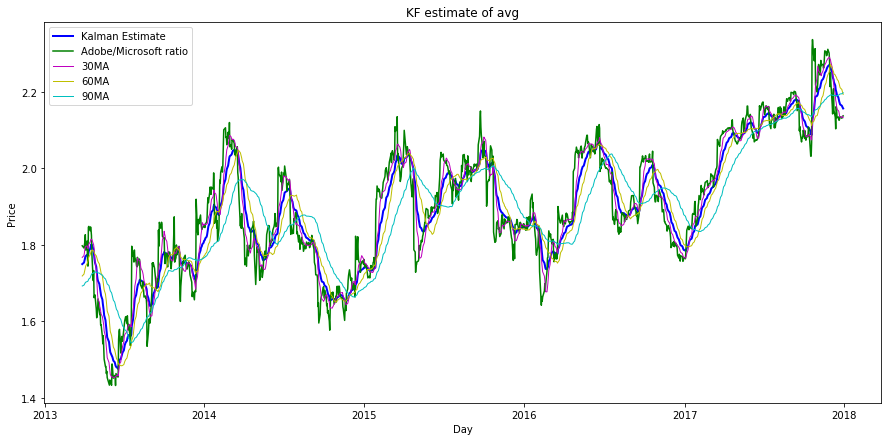

In [72]:
plt.figure(figsize = (15,7))
plt.plot(state_means[60:], '-b', lw = 2,)
plt.plot(x[60:], '-g', lw = 1.5)
plt.plot(mean30[60:], 'm', lw = 1)
plt.plot(mean60[60:], 'y', lw = 1)
plt.plot(mean90[60:], 'c', lw = 1)

plt.title('KF estimate of avg')
plt.legend(['Kalman Estimate', 'Adobe/Microsoft ratio', '30MA', '60MA', '90MA'])
plt.xlabel('Day')
plt.ylabel('Price')

# Pairs trading 

In [73]:

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading2'
instrumentIds = ['ADBE', 'MSFT']

ds = YahooStockDataSource(cachedFolderName = cachedFolderName,
    dataSetId = dataSetId,
    instrumentIds = instrumentIds,
    startDateStr = startDateStr,
    endDateStr = endDateStr,
    event = 'history')

data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: ADBE
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


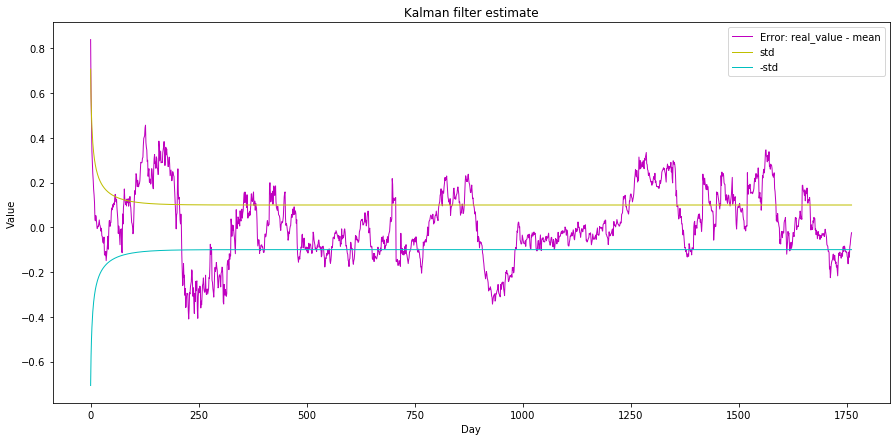

In [75]:
S1, S2 = data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762]
ratios = S1/S2

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

state_means, state_cov = kf.filter(ratios.values)
state_means, state_std = state_means.squeeze(), np.std(state_cov.squeeze())

plt.figure(figsize=(15,7))
plt.plot(ratios.values - state_means, 'm', lw=1)
plt.plot(np.sqrt(state_cov.squeeze()), 'y', lw=1)
plt.plot(-np.sqrt(state_cov.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value');

# Moje 

In [3]:
import numpy as np
import pandas as pd
import  statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(107)
import matplotlib.pyplot as plt
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

In [5]:
startDateStr = '2017/11/01'
endDateStr = '2019/11/01'
cachedFolderName = 'yahooData/'
dataSetId = 'kalmanFilter'
instrumentIds = ['SPY', 'AAPL', 'LMT']

ds = YahooStockDataSource(cachedFolderName = cachedFolderName,
    dataSetId = dataSetId,
    instrumentIds = instrumentIds,
    startDateStr = startDateStr,
    endDateStr = endDateStr,
    event = 'history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: LMT
20% done...
40% done...
60% done...
80% done...


In [6]:
data.head()

,SPY,AAPL,LMT
2017-10-31,241.889999,40.521748,283.764954
2017-11-01,242.209824,40.006359,282.328461
2017-11-02,242.303925,40.298813,286.251190
2017-11-03,243.112885,41.351170,285.450104
2017-11-06,243.489136,41.770676,285.532898


In [8]:
from pykalman import KalmanFilter
#construct filter
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1],
                 initial_state_mean = 0,
                 initial_state_covariance = 1,
                 observation_covariance = 1,
                  transition_covariance = .01)
                  

In [10]:
# rolling mean:
x = data.AAPL
state_means, _ = kf.filter(x.values)

In [12]:
state_means = pd.Series(state_means.flatten(), index = x.index)

2017-10-31    20.260874
2017-11-01    26.929879
2017-11-02    30.379354
2017-11-03    32.698467
2017-11-06    34.342780
                ...    
2019-10-25    57.826444
2019-10-28    58.180136
2019-10-29    58.364783
2019-10-30    58.531159
2019-10-31    58.810998
Length: 504, dtype: float64

In [19]:
state_means.tail()

2019-10-25    57.826444
2019-10-28    58.180136
2019-10-29    58.364783
2019-10-30    58.531159
2019-10-31    58.810998
dtype: float64

In [14]:
# rolling mean with various lookbach windows:
mean50 = x.rolling(window = 50).mean()
mean100 = x.rolling(window = 100).mean()

In [18]:
mean100.tail()

2019-10-25    52.143358
2019-10-28    52.302826
2019-10-29    52.435923
2019-10-30    52.562963
2019-10-31    52.698105
Name: AAPL, dtype: float64

Text(0, 0.5, 'Price')

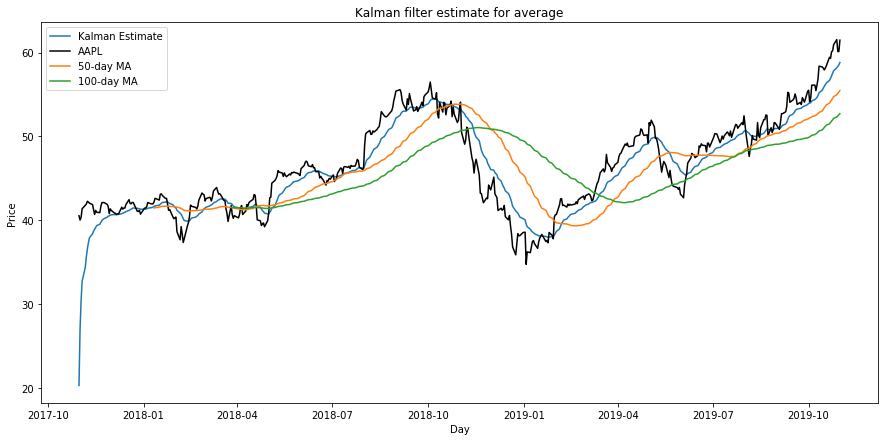

In [24]:
plt.figure(figsize = (15,7))
plt.plot(state_means)
plt.plot(x, color = 'k')
plt.plot(mean50)
plt.plot(mean100)
plt.title('Kalman filter estimate for average')
plt.legend(['Kalman Estimate', 'AAPL', '50-day MA', '100-day MA'])
plt.xlabel('Day')
plt.ylabel('Price')

In [26]:
delta = 1e-3
delta

0.001

In [27]:
trans_cov = delta/(1-delta) * np.eye(2)
trans_cov

array([[0.001001, 0.      ],
       [0.      , 0.001001]])

In [28]:
np.eye(3) * 2

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [38]:
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis =1)
obs_mat[:2]

array([[[40.521748,  1.      ]],

       [[40.006359,  1.      ]]])

In [37]:
x.head(2)

2017-10-31    40.521748
2017-11-01    40.006359
Name: AAPL, dtype: float64

In [35]:
np.vstack([[x], [np.ones(len(x))]])

array([[40.521748, 40.006359, 40.298813, ..., 60.121231, 60.113815,
        61.472961],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ]])

In [42]:
kf1 = KalmanFilter(n_dim_obs =1, n_dim_state = 2,
                  initial_state_mean = [0,0],
                  initial_state_covariance = np.ones((2,2)),
                  transition_matrices = np.eye(2),
                   observation_matrices = obs_mat,
                   observation_covariance = 2,
                   transition_covariance = trans_cov
                  )

state_means, state_covs = kf.filter(y.values)

NameError: name 'y' is not defined